# Correcting absolute hydration free energies using support vector machines - null test

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Global-variables" data-toc-modified-id="Global-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Global variables</a></span></li><li><span><a href="#Path-variables" data-toc-modified-id="Path-variables-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Path variables</a></span><ul class="toc-item"><li><span><a href="#Convergence-plot" data-toc-modified-id="Convergence-plot-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Convergence plot</a></span></li></ul></li><li><span><a href="#External-testing" data-toc-modified-id="External-testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>External testing</a></span><ul class="toc-item"><li><span><a href="#Pearson-R" data-toc-modified-id="Pearson-R-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Pearson R</a></span></li><li><span><a href="#RMS" data-toc-modified-id="RMS-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>RMS</a></span></li><li><span><a href="#Mean-absolute-error" data-toc-modified-id="Mean-absolute-error-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Mean absolute error</a></span></li><li><span><a href="#Kendall-$\tau$" data-toc-modified-id="Kendall-$\tau$-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Kendall $\tau$</a></span></li><li><span><a href="#Linear-combination" data-toc-modified-id="Linear-combination-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Linear combination</a></span></li><li><span><a href="#Load-test-data" data-toc-modified-id="Load-test-data-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Load test data</a></span></li><li><span><a href="#Predict-$\Delta-G_{hydr}$" data-toc-modified-id="Predict-$\Delta-G_{hydr}$-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Predict $\Delta G_{hydr}$</a></span></li></ul></li><li><span><a href="#Removing-outlier" data-toc-modified-id="Removing-outlier-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Removing outlier</a></span></li></ul></div>

## Imports

In [1]:
# General:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import csv
import time
import scipy
import shutil
import logging
import pickle
import statistics
from tqdm import tqdm_notebook as tqdm
from uncertainties import unumpy

# SVM:
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from skopt import gp_minimize, dump, load
os.environ["CUDA_VISIBLE_DEVICES"]="3"  # current workstation contains 4 GPUs; exclude 1st

# SciKit-Optimise:
from skopt import gp_minimize, dump
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# Statistics:
from uncertainties import unumpy
import itertools
itertools.imap = lambda *args, **kwargs: list(map(*args, **kwargs))

/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Global variables

In [2]:
# Global variables:
model_type = 'null_DNN'
label_col = 'Experimental dGhydr (kcal/mol)'
# label_col = 'dGoffset (kcal/mol)'
label_u_col = 'uncertainty (kcal/mol)'

# set data processing configurations:
n_calls = 60  # Number of Bayesian optimisation loops for hyperparameter optimisation, 40 is best for convergence, > 60 scales to very expensive
best_mae = np.inf  # Point to consider top-performing model from (MAE/MAD); 1.0 = no improvement on test-set variance

# KFold parameters:
n_splits = 5  # Number of K-fold splits
random_state = 2  # Ranom number seed

# DNN global variables
n_calls = 60  # Number of Bayesian optimisation loops for hyperparameter optimisation, 40 is best for convergence, > 60 scales to very expensive
epochs = 200
best_mae = np.inf

colour1 = 'darkgray'
colour2 = 'green'
colour3 = 'lightsteelblue'

In [3]:
figsize = [8, 6]
fontsize = 18
markersize = 20
linewidth = 2
dGhydr_xlim = [-25.0, 2.5]
dGhydr_ylim = [-25.0, 2.5]
colour1 = 'darkgray'
colour2 = 'green'
colour3 = 'lightsteelblue'

## Path variables

In [4]:
# Path variables:
path = './'
datasets_dr = '../datasets/'
SDF_dr = datasets_dr + 'sdffiles/'
output_dr = path + 'output_null/'
if not os.path.exists(output_dr):
    os.mkdir(output_dr)
figures_dr = path + 'figures_null/'
if not os.path.exists(figures_dr):
    os.mkdir(figures_dr)
freesolv_loc = datasets_dr + 'freesolv_database.txt'

### Convergence plot

Load gp_minimize objects

In [5]:
# gp_minimize object
gp_results = [load(output_dr + 'fold_' + str(fold_num) +  '_gp_minimize_result.pickle') 
              for fold_num in range(1, n_splits + 1)]
# lsit of MAE and associated parameters
mae_logger = pd.read_csv(output_dr + 'DNN_statistics.csv')

/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.20.0 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Plot function convergence over number of calls

In [6]:
def mae_convergence(dataframe):

    # x values
    x = np.linspace(1, n_calls, n_calls)

    # y values
    mae = [dataframe.loc[dataframe.iloc[:, 0] == fold, 'MAE (kcal/mol)'].cummin()
           for fold in range(1, n_splits + 1)]
    cumm_mae = list(zip(*mae))
    y = [statistics.mean(call) for call in cumm_mae]

    # standard devation
    std = [statistics.stdev(call) for call in cumm_mae]

    # standard devation bounds
    y1 = [i - sd for i, sd in zip(y, std)]
    y2 = [i + sd for i, sd in zip(y, std)]

    # plot mean line
    fig, ax = plt.subplots(figsize=figsize)
    for axis in ['top','bottom','left','right']: ax.spines[axis].set_linewidth(linewidth)

    ax.plot(x, y,
            color=colour2,
            linewidth=linewidth,
            label='Average MAE over {} folds'.format(n_splits))

    # plot standard deviation fill bounds
    ax.fill_between(x, y1, y2,
                    fc=colour3,
                    ec=colour3,
                    label='Standard deviation')

    ax.set_xlabel('Number of calls $n$', fontsize=fontsize)
    ax.set_ylabel('MAE / kcal mol$^{-1}$', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    ax.legend(fontsize=fontsize)
    plt.tight_layout()
    
    fig.savefig(figures_dr + 'convergence_plot.png')
    
    return ax

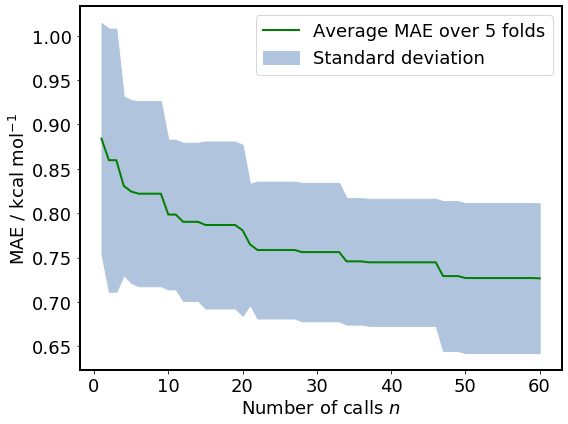

In [7]:
mae_logger = output_dr + 'DNN_statistics.csv'
mae_df = pd.read_csv(mae_logger)  # Load previously defined training statistics logger.
mae_convergence(mae_df)  # Plot convergence plot.

## External testing

### Pearson R


$
  r =
  \frac{ \sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y}) }{%
        \sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i-\bar{y})^2}}
$

In [8]:
def calc_pearson_r(x, y):
    """
    Calculates Pearson R value.
    Assumes len(x) == len(y).
    Parameters
    ----------
    x: array like of uncertainties.core.Variable
    y: array like of uncertainties.core.Variable
    ----------
    Returns array like of uncertainties.core.Variable
    """
    n = len(x)  # number of samples
    x_norm = [i.n for i in x]  # x without uncertainty
    y_norm = [i.n for i in y]  # y without uncertainty
    sum_x = float(sum(x_norm))  # sum of x
    sum_y = float(sum(y_norm))  # sum of y
    sum_x_sq = sum(itertools.imap(lambda x: pow(x, 2), x))  # sum of x**2
    sum_y_sq = sum(itertools.imap(lambda x: pow(x, 2), y))  # sum of y**2
    psum = sum(itertools.imap(lambda x, y: x * y, x, y))  # sum of x*y
    num = psum - (sum_x * sum_y/n)  # Pearson R equation numerator
    den = pow((sum_x_sq - pow(sum_x, 2) / n) * (sum_y_sq - pow(sum_y, 2) / n), 0.5)  # Pearson R formular demoninator
    if den == 0: return 0  # Prevent division by zero
    return num / den

### RMS

In [9]:
def rmse(x, y):
    """Returns the root means squared error of two lists.
    Assumes len(x) == len(y)"""
    num = sum([(i - j)**2 for i, j in zip(x, y)])
    den = len(x)
    return (num / den)**0.5

### Mean absolute error


$
<insert \: formula>
$

In [10]:
def calc_mae(x, y):
    """Returns list of mean absolute error between two lists.
    Assumes len(x) == len(y)."""
    ae = [abs(i - j) for i, j in zip(x, y)]
    return sum(ae) / len(ae)

### Kendall $\tau$

In [11]:
def kendall_tau(x, y):
    tau, p_value = scipy.stats.kendalltau(x, y)
    return tau

### Linear combination

In [12]:
def sum_error(error1, error2):
    """Returns sum propagated error between two int or floats."""
    return (error1 ** 2 + error2 ** 2) ** 0.5

### Load test data

In [13]:
null_test_X = pd.read_csv(datasets_dr + 'null_test_data.csv', index_col='ID').iloc[:,:-2].sort_index()
null_test_y = pd.read_csv(datasets_dr + 'null_test_data.csv', index_col='ID').iloc[:,-2:].sort_index()
test_ID = null_test_y.index

### Predict $\Delta G_{hydr}$

In [14]:
def model_predict(model_num, test_entry):
    """Load model from HDF5 and return model prediction on a given test_entry."""

    model = tf.keras.models.load_model(output_dr + 'dGhydr_DNN_fold_' + str(model_num) + '_model.h5')

    return model.predict(test_entry)

In [15]:
null_predict_per_fold = [model_predict(fold_num, null_test_X.to_numpy()) for fold_num in range(1, n_splits + 1)]
null_predict_per_fold = [np.asarray([x[0] for x in fold.tolist()]) for fold in null_predict_per_fold]
null_predicted_y = pd.DataFrame(data={'Average predicted dGhydr (kcal/mol)': [float(x) for x in np.average(null_predict_per_fold, axis=0)],
                                      'Standard deviation (kcal/mol)': np.std(null_predict_per_fold, axis=0)},
                           index=test_ID)

In [31]:
pathname = output_dr + 'null_predicted_dGhydr_DNN.csv'
null_predicted_y.to_csv(pathname, index=True, index_label='ID')
print(pathname)

./output_null/null_predicted_dGhydr_DNN.csv


In [16]:
def plot_scatter(calc, exp, title, x_label, y_label, colour):
    """
    Returns and saves linear regression scatter plot.
    Note: takes pre-defined global variables: figsize, linewidth, fontsize, dGhydr_xlim, dGhydr_ylim, markersize, colour1 and colour2,
    and pre-defined functions: calc_mae() and calc_pearson_r().
    Parameters
    ----------
    calc: (DataFrame) calculated data at column index 0 with associated errors at column index 1.
    exp: (DataFrame) experimental data at column index 0 with associated errors at column index 1.
    title: (str) plot title and filename delimitted by underscores. Avoid special characters.
    x_label: (str) x-axis label.
    y_label: (str) y-axis label.
    """
    
    # Unpack data.
    x = calc.iloc[:,0]
    y = exp.iloc[:,0]
    
    # Setup figure.
    fig, ax = plt.subplots(figsize=figsize)
    for axis in ['top','bottom','left','right']: ax.spines[axis].set_linewidth(linewidth)  # Frame line width.
    ax.tick_params(axis='both', which='major', labelsize=fontsize)  # Axis number font size.
    ax.set_xlabel(x_label, fontsize=fontsize)  # X-axis label font size.
    ax.set_ylabel(y_label, fontsize=fontsize)  # Y-axis label font size.
    ax.set_xlim(dGhydr_xlim)  # X-axis range.
    ax.set_ylim(dGhydr_ylim)  # Y-axis range.
    
    # Plot scatter.
    ax.scatter(x, y, color=colour, s=markersize)

    # Plot line of best fit.
    ax.plot(np.unique(x),
             np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),
             color='black', linewidth=linewidth)

    # Create uncertainties.core.Variable for statistical analysis
    xu = unumpy.uarray(calc.iloc[:,0], calc.iloc[:,1])
    yu = unumpy.uarray(exp.iloc[:,0], exp.iloc[:,1])
    
    # Calculate mean absolute error.
    mae = calc_mae(xu, yu)
    
    # Calculate Pearson R.
    r_value = calc_pearson_r(xu, yu)

    # Annotate with mean absolute error and Pearson R.
    string = 'MAE = {} {}\nR = {}'.format(mae, 'kcal mol$^{-1}$', r_value).replace('+/-', '$\pm$')
    ax.annotate(string, xy=(0, 1), xytext=(12, -12), va='top',
                 xycoords='axes fraction', textcoords='offset points',
                 size=fontsize)

    # Save figure using the title as filename.
    filename = figures_dr + str(title).lower().replace(' ', '_') + '.png'
    plt.savefig(filename)
    logging.info('Saved {}.'.format(filename))

In [17]:
freesolv_df = pd.read_csv(freesolv_loc, sep='; ', engine='python').rename(columns={'compound id (and file prefix)': 'ID'})
freesolv_df = freesolv_df.set_index('ID').sort_index()
test_exp = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie',
                           ['experimental value (kcal/mol)', 'experimental uncertainty (kcal/mol)']].sort_index()
test_fep = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie',
                           ['Mobley group calculated value (GAFF) (kcal/mol)', 'calculated uncertainty (kcal/mol)']].sort_index()

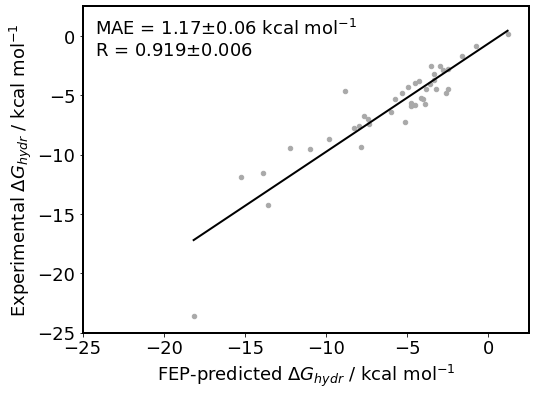

In [18]:
plot_scatter(calc=test_fep,
             exp=test_exp,
             title='Original test set hydraton free energy',
             x_label='FEP-predicted $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             colour=colour1)

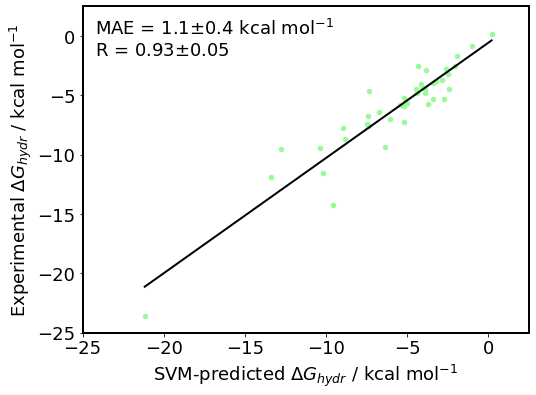

In [19]:
plot_scatter(calc=null_predicted_y,
             exp=null_test_y,
             title='DNN-predicted test set dGhydr',
             x_label='SVM-predicted $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             colour='palegreen')

In [20]:
def plot_scatter_with_arrows(calc, exp, corr):
    """
    Returns and saves several overlayed plots:
    1. Uncorrected scatter plot between calculated and experiemntal values.
    2. Corrected scatter plot between corrections and experiemntal values.
    3. Line of best fit for the aforementioned corrected scatter plot.
    4. Arrows in the form of annotations between respective uncorrected and corrected scatter points.
    Note: takes pre-defined global variables: linewidth, fontsize, dGhydr_xlim, dGhydr_ylim, markersize, colour1 and colour2,
    and pre-defined functions: calc_mae() and calc_pearson_r().
    ----------
    Parameters
    ----------
    calc: (DataFrame) calculated data at column index 0 with associated errors at column index 1.
    exp: (DataFrame) experimental data at column index 0 with associated errors at column index 1.
    offsets: (DataFrame) predicted offsets at column index 0 with associated errors at column index 1.
    corr: (DataFrame) corrected calculated data at column index 0 with associated errors at column index 1.
    """
    
    # Unpack data.
    x_fep = calc.iloc[:,0]
    x_ml = corr.iloc[:,0]
    y = exp.iloc[:,0]
    
    # Setup figure.
    fig, ax = plt.subplots(figsize=[15,10])
    for axis in ['top','bottom','left','right']: ax.spines[axis].set_linewidth(linewidth)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_xlabel('Predicted $\Delta G_{hydr}$ / kcal mol$^{-1}$', fontsize=fontsize)
    ax.set_ylabel('Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$', fontsize=fontsize)
    ax.set_xlim(dGhydr_xlim)
    ax.set_ylim(dGhydr_ylim)
    
    # Plot FEP vs exp and FEP+ML vs exp.
    ax.scatter(x_fep, y, color=colour1, s=markersize, label='FEP')
    ax.scatter(x_ml, y, color=colour2, s=markersize, label='FEP+DNN')
    
    # Plot line of best fit.
    ax.plot(np.unique(x_ml),
         np.poly1d(np.polyfit(x_ml, y, 1))(np.unique(x_ml)),
         color='black', linewidth=linewidth)
    
    # Annotate with arrows.
    for ml, f, e in zip(x_ml, x_fep, y):
        fep_corrected = ml
        fep_offset = e - f
        fep_corrected_offset = e - fep_corrected
        
        if abs(fep_corrected_offset) <= abs(fep_offset):
            line_color = "green"
        else:
            line_color = "red"
            
        ax.annotate("", xytext=(f, e), xy=(fep_corrected, e), 
                     arrowprops=dict(arrowstyle="->", color=line_color))

    # create uncertainties.core.Variable for statistical analysis
    xu = unumpy.uarray(corr.iloc[:,0], corr.iloc[:,1])
    yu = unumpy.uarray(exp.iloc[:,0], exp.iloc[:,1])
    
    # mean absolute error
    mae = calc_mae(xu, yu)
    
    # Pearson R and R-squared
    r_value = calc_pearson_r(xu, yu)

    # annotate with r-squared and MAE
    string = 'MAE = {} {}\nR = {}'.format(mae, 'kcal mol$^{-1}$', r_value).replace('+/-', '$\pm$')
    ax.annotate(string, xy=(0, 1), xytext=(12, -12), va='top',
                 xycoords='axes fraction', textcoords='offset points',
                 size=fontsize)

    # Create legend.
    plt.legend(loc='lower right', fontsize=fontsize)
    
    # Save figure.
    filename = figures_dr + 'offset_mapping.png'
    plt.savefig(filename)
    logging.info('Saved {}.'.format(filename))

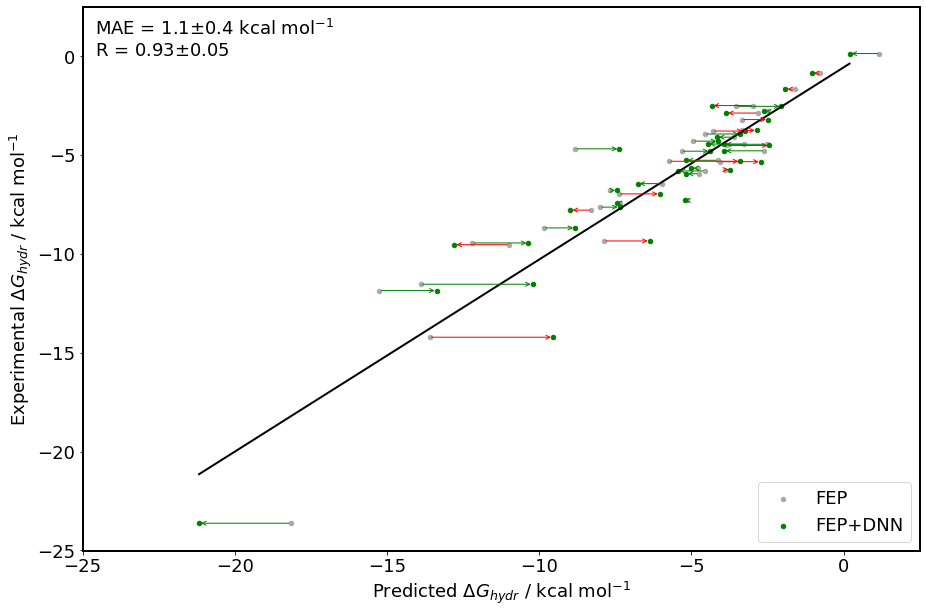

In [21]:
plot_scatter_with_arrows(calc=test_fep,
                         exp=test_exp,
                         corr=null_predicted_y)

## Removing outlier

In [22]:
outlier = 'mobley_4587267'

In [23]:
# Remove outlier from all pre-defined DataFrames.
test_ID_o = test_ID.drop(outlier)
test_X_o = null_test_X.iloc[null_test_X.index != outlier, :]
test_y_o = null_test_y.iloc[null_test_y.index != outlier, :]
test_fep_o = test_fep.iloc[test_fep.index != outlier, :]
test_exp_o = test_exp.iloc[test_exp.index != outlier, :]

# Perform new offset predictions.
null_predict_per_fold_o = [model_predict(fold_num, test_X_o.to_numpy()) for fold_num in range(1, n_splits + 1)]
null_predict_per_fold_o = [np.asarray([x[0] for x in fold.tolist()]) for fold in null_predict_per_fold_o]
null_predicted_y_o = pd.DataFrame(data={'Average predicted dGhydr (kcal/mol)': [float(x) for x in np.average(null_predict_per_fold_o, axis=0)],
                                      'Standard deviation (kcal/mol)': np.std(null_predict_per_fold_o, axis=0)},
                           index=test_ID_o)

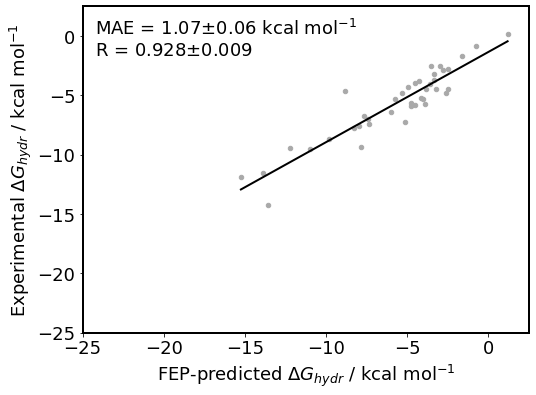

In [24]:
plot_scatter(calc=test_fep_o,
             exp=test_exp_o,
             title='Original test set hydraton free energy with removed outlier',
             x_label='FEP-predicted $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             colour=colour1)

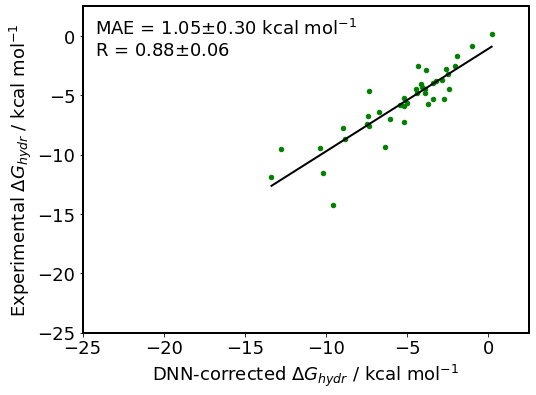

In [25]:
plot_scatter(calc=null_predicted_y_o,
             exp=test_y_o,
             title='DNN-corrected test set hydraton free energy with outlier removed',
             x_label='DNN-corrected $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             colour=colour2)

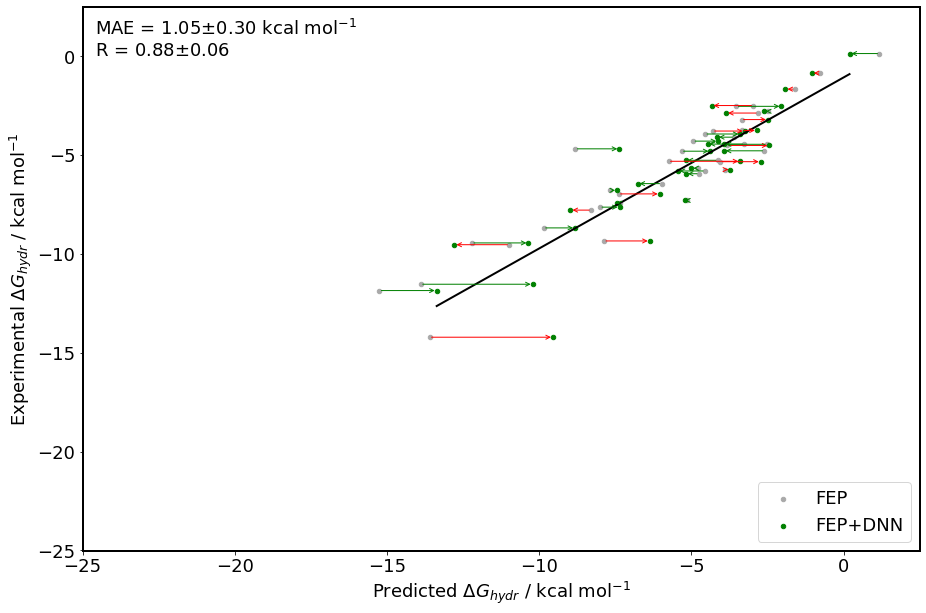

In [26]:
plot_scatter_with_arrows(calc=test_fep_o,
                         exp=test_exp_o,
                         corr=null_predicted_y_o)